In [34]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 
import json

home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import torch
import matplotlib.pyplot as plt
from skimage.io import imread

torch.version.cuda # 10.2

# Note, for installation issues:
# Ensure you download the correct cudatoolkit for torch:
# https://discuss.pytorch.org/t/pytorch-for-cuda-10-2/65524/4
# Ensure you've got the right torch:
# https://github.com/facebookresearch/pytorch3d/issues/443

'10.2'

In [20]:
# !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
# !tar xzf 1.10.0.tar.gz
os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
# !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [21]:
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

In [22]:
# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
sys.path.append(os.path.abspath(''))

In [23]:
# !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

In [24]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

In [25]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

In [26]:
mesh

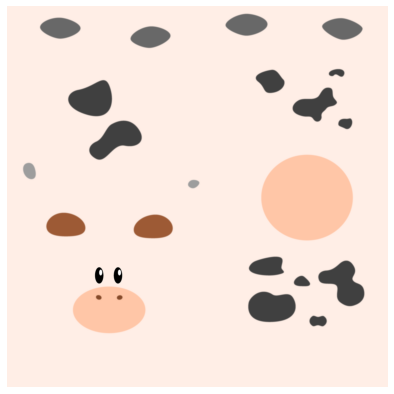

In [27]:
plt.figure(figsize=(7,7))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis("off");

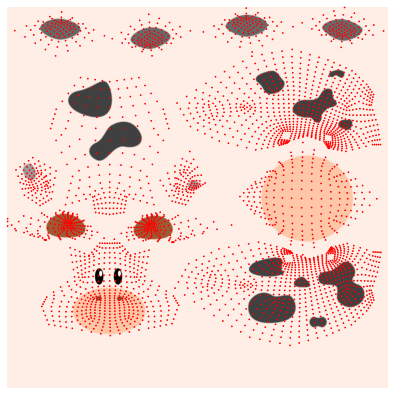

In [28]:
plt.figure(figsize=(7,7))
texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.grid("off");
plt.axis("off");

In [38]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(dist=2.7, elev=0, azim=180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [32]:
images = renderer(mesh)
#mesh

In [58]:
#fd(mesh, 'verts')
import numpy as np 

m = np.array(mesh.verts_list()[0])

xx = m[:, 0].min(), m[:, 2].max()
yy = m[:, 1].min(), m[:, 2].max()
zz = m[:, 2].min(), m[:, 2].max()

print(xx)
print(yy)
print(zz)

(-0.471552, 1.049)
(-0.736784, 1.049)
(-0.668909, 1.049)


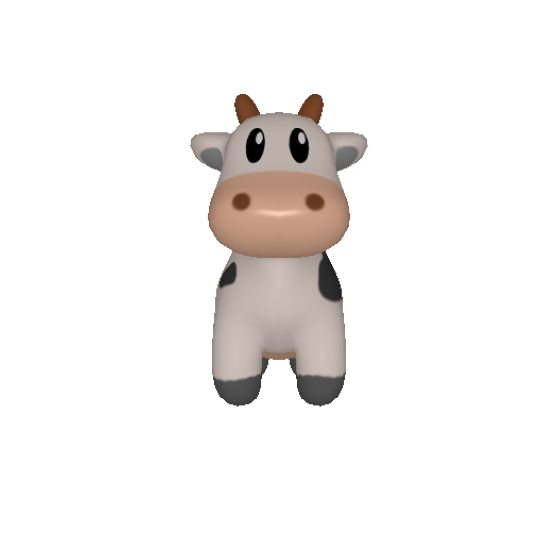

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");